In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.rdcgan as rdcgan
import networks.utils as utils

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-128")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 128
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 128
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 6
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "radcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 5
SAVE_FAKES_EVERY_N_EPOCHS = 1

#MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_22-31-31/gan_at_epoch_0020.pt")
MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=PIN_MEMORY)

Sample dataset:

The dataset has 224094 entries.


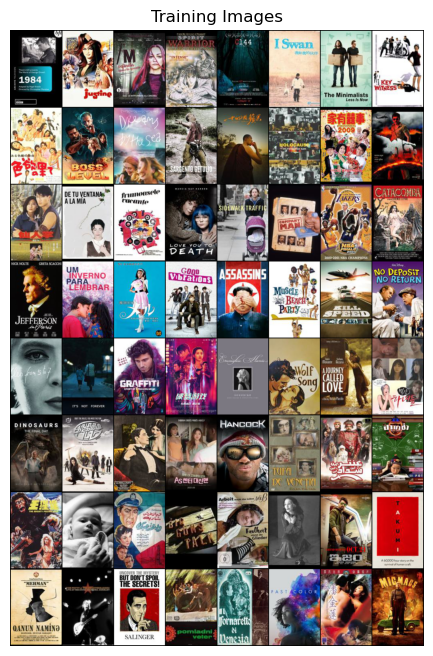

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = rdcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO,
                                            num_img_channels=NUM_IMG_CHANNELS,
                                            num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                            base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                            base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                            device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, IMAGE_SIZE * IMAGE_SIZE_RATIO // 2, IMAGE_SIZE))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 6, 4]       2,097,152
       BatchNorm2d-2           [-1, 1024, 6, 4]           2,048
              ReLU-3           [-1, 1024, 6, 4]               0
   ConvTranspose2d-4           [-1, 512, 12, 8]       8,388,608
       BatchNorm2d-5           [-1, 512, 12, 8]           1,024
              ReLU-6           [-1, 512, 12, 8]               0
   ConvTranspose2d-7          [-1, 256, 24, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 24, 16]             512
              ReLU-9          [-1, 256, 24, 16]               0
  ConvTranspose2d-10          [-1, 128, 48, 32]         524,288
      BatchNorm2d-11          [-1, 128, 48, 32]             256
             ReLU-12          [-1, 128, 48, 32]               0
  ConvTranspose2d-13           [-1, 64, 96, 64]         131,072
      BatchNorm2d-14        

In [8]:
trainer = rdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                               num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                               d_params=discriminator.parameters(), g_params=generator.parameters(),
                               learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

[0/5]	Loss_D: 0.0619	Loss_G: 4.4820	D(x): 0.7919	D(G(z)): -0.0281 / -0.2979: 100%|██████████| 3502/3502 [20:51<00:00,  2.80it/s]   


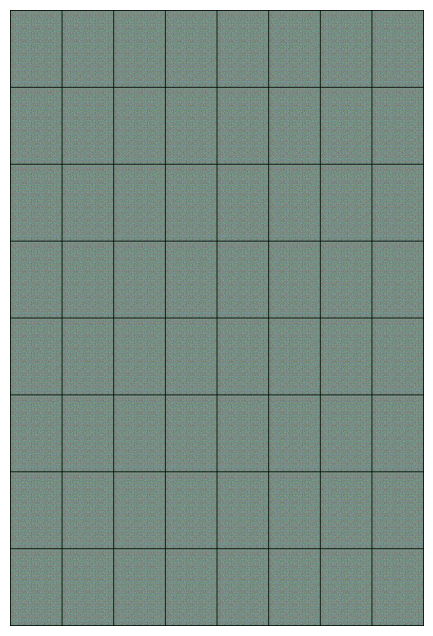

[1/5]	Loss_D: 0.0571	Loss_G: 5.0998	D(x): 1.0288	D(G(z)): -0.1473 / -0.2070: 100%|██████████| 3502/3502 [21:23<00:00,  2.73it/s] 


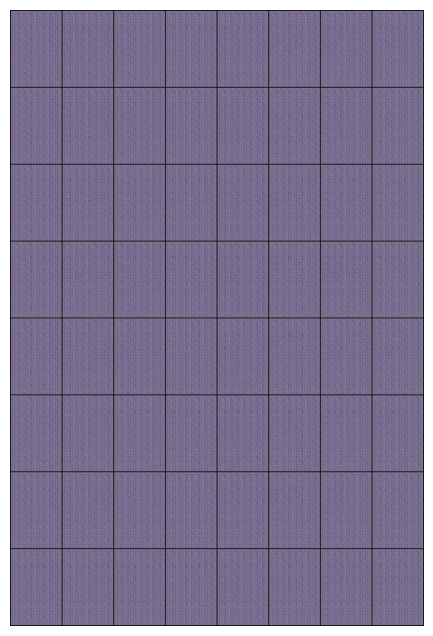

[2/5]	Loss_D: 0.5579	Loss_G: 3.2152	D(x): 1.1020	D(G(z)): 0.8332 / 0.4021: 100%|██████████| 3502/3502 [19:45<00:00,  2.95it/s]   


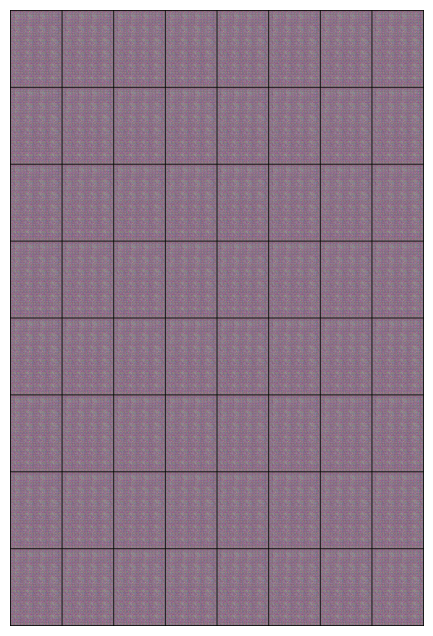

[3/5]	Loss_D: 0.2540	Loss_G: 4.5959	D(x): -0.3161	D(G(z)): -1.1248 / -1.2812: 100%|██████████| 3502/3502 [19:38<00:00,  2.97it/s]


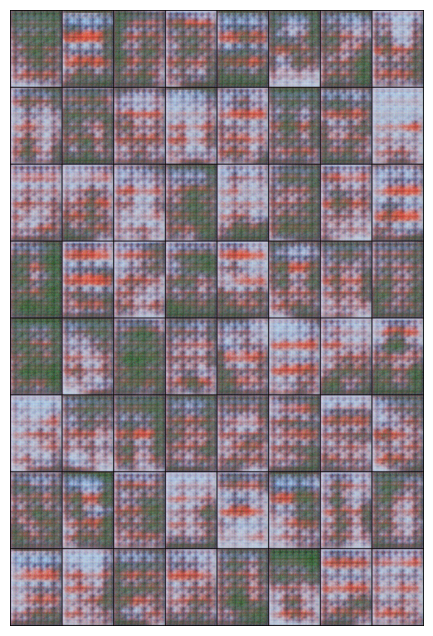

[4/5]	Loss_D: 0.1972	Loss_G: 4.5407	D(x): 0.0344	D(G(z)): -0.8788 / -0.9841: 100%|██████████| 3502/3502 [19:19<00:00,  3.02it/s] 


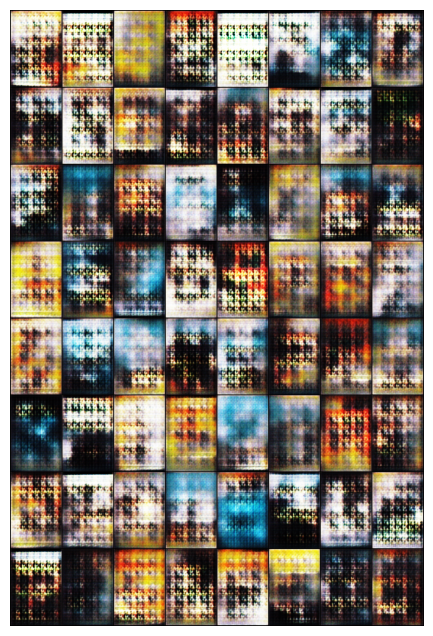

[5/5]	Loss_D: 0.0939	Loss_G: 6.0005	D(x): -0.3719	D(G(z)): -1.2820 / -1.7018: 100%|██████████| 3502/3502 [19:26<00:00,  3.00it/s]


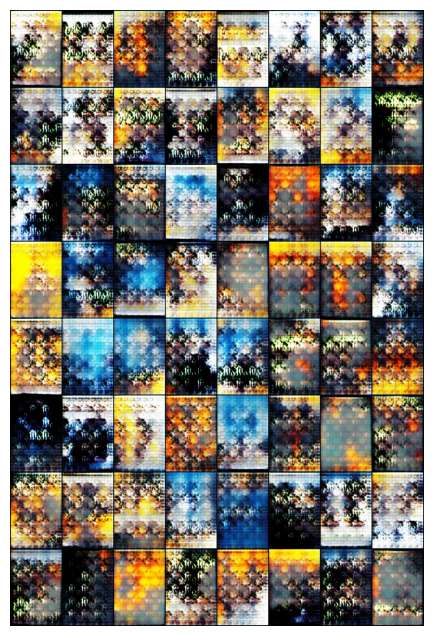

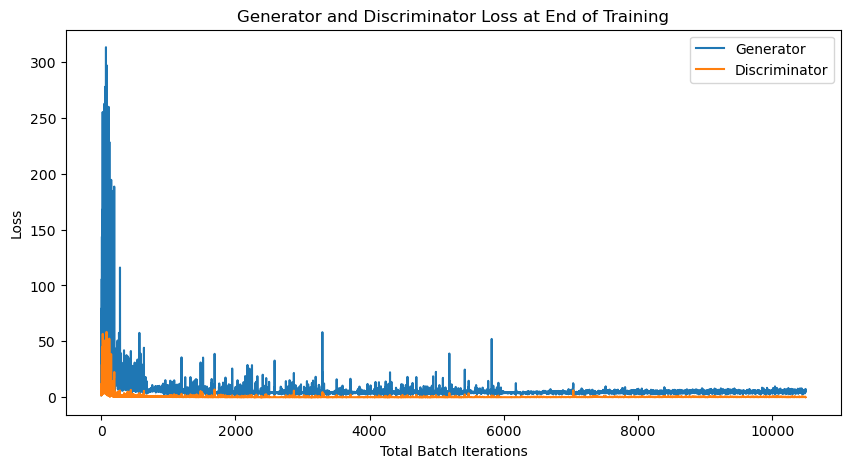

In [9]:
SHOW_GRAPHS = True
trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device,
              fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS,
              model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS)

### Show results

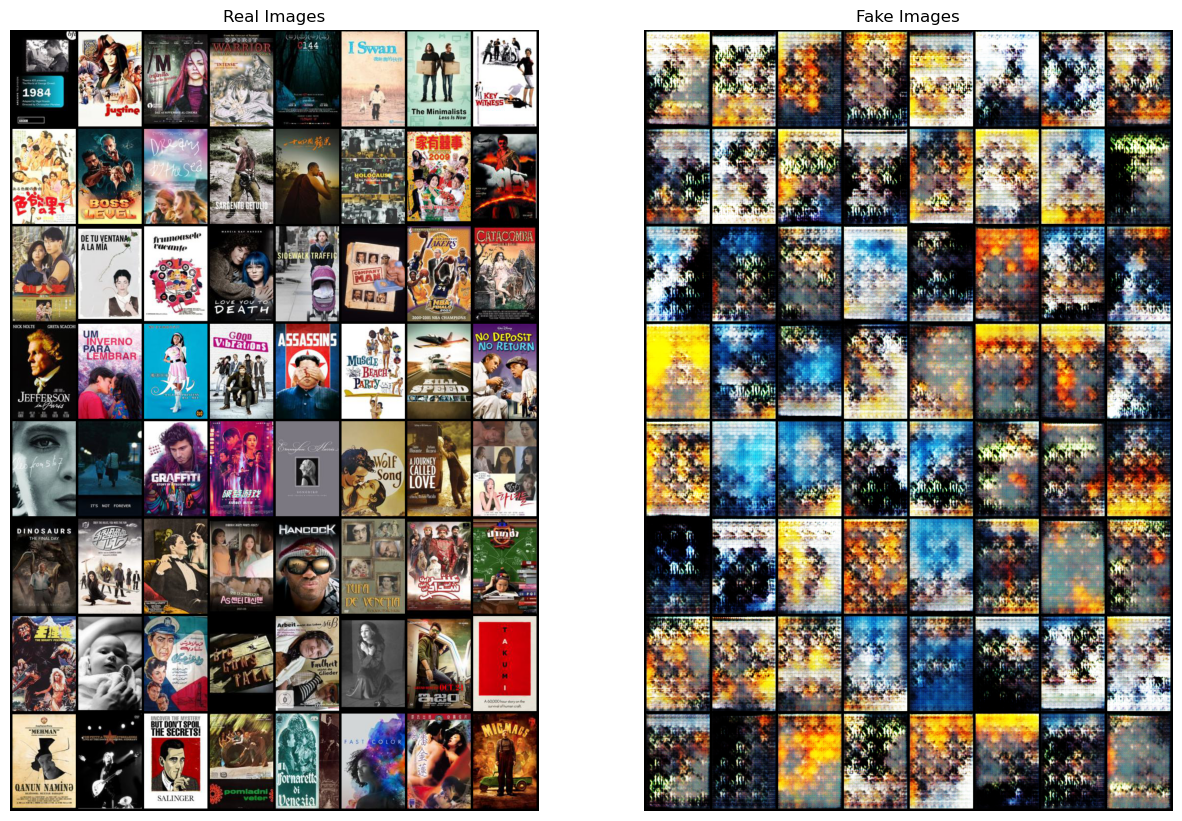

In [10]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device)

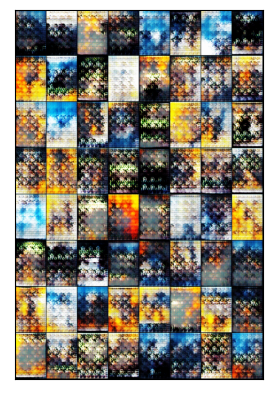

In [11]:
from sample_and_visualize import sample_and_visualize

sample_and_visualize(generator, NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 64, device, 0.01)